# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner 


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /Harvard-IACS/2018-CS109A/master/content/styles/cs109.css (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x105873e20>: Failed to establish a new connection: [Errno 61] Connection refused'))

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

<div class='exercise'><b> Question 1 [50 pts]: Modeling seasonality of Airbnb prices </b></div>

In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

**1.1** Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`


**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.


**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

* **1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

* **1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

* **1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.

* **1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?  

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?


**1.1** Start by loading the data using pandas.
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`



In [3]:
# your code here
train = pd.read_csv('data/calendar_train.csv', parse_dates = [1])
test = pd.read_csv('data/calendar_test.csv', parse_dates = [1])

In [4]:
train.head()

,listing_id,date,available,price
0,20872145,2018-09-21,f,NaN
1,20872145,2018-09-19,f,NaN
2,20872145,2018-09-18,f,NaN
3,20872145,2018-09-17,f,NaN
4,20872145,2018-09-16,f,NaN


**1.2** Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.



In [5]:
# your code here

# add the month info
month = []
for i in train['date']:
    result = i.month
    month.append(result)

train['month'] = month

# add the weekday info
weekday_int = []
weekday_wd = []

def get_week_day(date):
    week_day_dict = {
        0 : 'Monday',
        1 : 'Tuesday',
        2 : 'Wednesday',
        3 : 'Thursday',
        4 : 'Friday',
        5 : 'Saturday',
        6 : 'Sunday',
      }
    return week_day_dict[date]

for i in train['date']:
    result = i.weekday()
    weekday_int.append(result)
    weekday_wd.append(get_week_day(result))
    

train['wday_int'] = weekday_int
train['wday_wd'] = weekday_wd

In [6]:
train.head()

,listing_id,date,available,price,month,wday_int,wday_wd
0,20872145,2018-09-21,f,NaN,9,4,Friday
1,20872145,2018-09-19,f,NaN,9,2,Wednesday
2,20872145,2018-09-18,f,NaN,9,1,Tuesday
3,20872145,2018-09-17,f,NaN,9,0,Monday
4,20872145,2018-09-16,f,NaN,9,6,Sunday


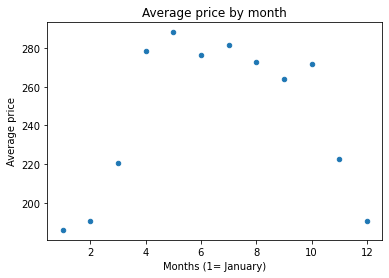

In [7]:
df = train.groupby('month')['price'].mean()
df = pd.DataFrame(df)
df['month'] = df.index
df.plot.scatter(x = 'month', y = 'price', title = 'Average price by month')
plt.xlabel("Months (1= January)")
plt.ylabel("Average price")
plt.show()

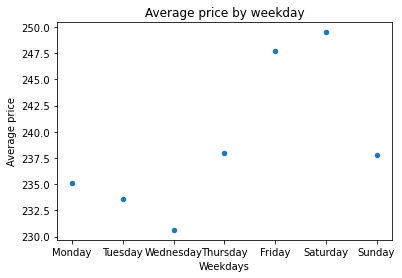

In [8]:
df = train.groupby('wday_int')['price'].mean()
df = pd.DataFrame(df)
df['wday_int'] = df.index
df['weekday'] = [get_week_day(i) for i in df.wday_int]
df.head()
df.plot.scatter(x = 'weekday', y = 'price', title = 'Average price by weekday')
plt.xlabel("Weekdays")
plt.ylabel("Average price")
plt.show()

**Answer:**
*For the average price by month, the graph shows that the price reaches the peak in April, May, and July. In general, late spring, summer, and early fall experience high price that are almost 25% higher than the general price in other months or seasons.*

*For the average price by weekday, the graph shows that there is a decreasing trend from Sunday to Wednesday. When the price reaches its lowest point, it rapidly increases for the following days and reaches its peak on Saturday. The price fluctuates from 230 to 250 per unit.*

**1.3** Explore different regression models. Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method. Make sure to fit your model on *all training set observations*. Do not average or otherwise combine the data before fitting.


*Important*: Convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

**1.3.1** Fit simple polynomial models of degree 2, 3, 5, and 8 via the `statsmodels` library to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.



In [9]:
# your code here

# 1. Prepare the date difference variable
# training set
earliest = train['date'].min()
day_dif = []
for i in range(0,len(train['date']),1):
    dif = (train['date'][i]-earliest).days
    day_dif.append(dif)
train['day_dif'] = day_dif
    
# test set    
earliest_t = test['date'].min()
day_dif_t = []
for i in range(0,len(test['date']),1):
    dif = (test['date'][i]-earliest_t).days
    day_dif_t.append(dif)
test['day_dif'] = day_dif_t

In [10]:
train.head()

,listing_id,date,available,price,month,wday_int,wday_wd,day_dif
0,20872145,2018-09-21,f,NaN,9,4,Friday,350
1,20872145,2018-09-19,f,NaN,9,2,Wednesday,348
2,20872145,2018-09-18,f,NaN,9,1,Tuesday,347
3,20872145,2018-09-17,f,NaN,9,0,Monday,346
4,20872145,2018-09-16,f,NaN,9,6,Sunday,345


In [11]:
# 2. Simple polynomial models of degree 2, 3, 5, and 8

# drop the NAs and prepare for the dataset
train_clean = train.dropna(subset = ['day_dif','price'])
test_clean = test.dropna(subset = ['day_dif','price'])
train_df = pd.DataFrame(train_clean.groupby('day_dif')['price'].mean())
test_df = pd.DataFrame(test_clean.groupby('day_dif')['price'].mean())
train_df['day_dif'] = train_df.index
test_df['day_dif'] = test_df.index

In [12]:
r2_train = []
r2_test = []

def get_pred_plot(n):
    
    fit_lm = sm.ols(formula="price ~ np.vander(day_dif, n+1, increasing=True) -1",data=train_df).fit()

    # calculate the R^2
    r2_train.append(fit_lm.rsquared)
    y_pred_test = fit_lm.get_prediction(test_df['day_dif']).summary_frame()['mean']
    r2_test.append(r2_score(test_df['price'],y_pred_test))

    # for the graphs on training sets
    pred_train = fit_lm.get_prediction(train_df['day_dif']).summary_frame()

    # plot the training set
    ax2 = train_df.plot.scatter(x='day_dif',y='price',c='Red',title="Average daily price vs. day difference on simple polynomial regressions of degree {}".format(n))
    ax2.set_xlabel("Day difference")
    ax2.set_ylabel("Average daily price")

    # plot the training prediction
    ax2.plot(train_df['day_dif'], pred_train['mean'], color="green")
    ax2.plot(train_df['day_dif'], pred_train['mean_ci_lower'], color="blue",linestyle="dashed")
    ax2.plot(train_df['day_dif'], pred_train['mean_ci_upper'], color="blue",linestyle="dashed");

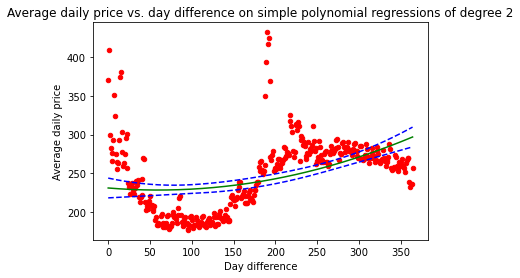

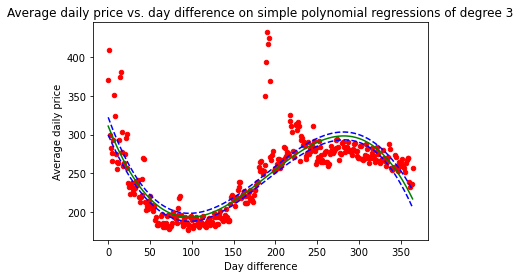

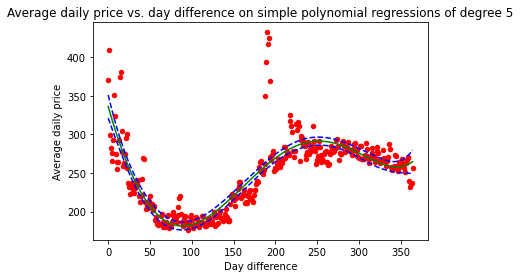

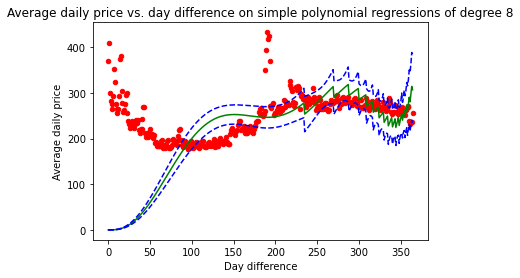

In [13]:
for i in [2,3,5,8]:
    get_pred_plot(i)

In [14]:
r2 = pd.DataFrame({'degree':[2,3,5,8],
                  'R^2 for training': r2_train,
                  'R^2 for test': r2_test})
r2

,degree,R^2 for training,R^2 for test
0,2,0.195848,0.200317
1,3,0.638003,0.613944
2,5,0.716899,0.685017
3,8,-3.973537,-3.677524


*From degree 2 to degree 5, the R^2s for both the training set and the test set increased, representing that the performance of the polynomial regression gets better. But for the degree 8, the performance just gets worse.*

**1.3.2** You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?


*Your answer here*

**1.3.3** Fit a penalized B-spline using `pygam` with the smoothness parameter chosen by cross-validation on the training set.  Again, provide the train and test scores of the best-performing model and plot its predictions.


In [15]:
# your code here

candidate_smoothings = [1.e-3, 1.e-2, 1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5]

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(train_df, train_df['price'])):
    train_ = train_df.iloc[train_index,:]
    test_ = train_df.iloc[test_index,:]
    for j, lam in enumerate(candidate_smoothings):
        gam = LinearGAM(s(0, lam=lam)).fit(train_['day_dif'],train_['price'])
        r2 = r2_score(test_['price'], gam.predict(test_['day_dif']))
        scores[i,j] = r2
        
lam_perform = np.mean(scores, axis=0)

# fit the best model
gam_best = LinearGAM(s(0, lam=candidate_smoothings[np.argmax(lam_perform)])).fit(train_df['day_dif'],train_df['price'])
r2_best = r2_score(test_df['price'], gam_best.predict(test_df['day_dif']))
r2_train = list(gam_best.statistics_['pseudo_r2'].values())[0]
y_pred_train = gam_best.predict(train_df['day_dif'])
y_pred_test = gam_best.predict(test_df['day_dif'])

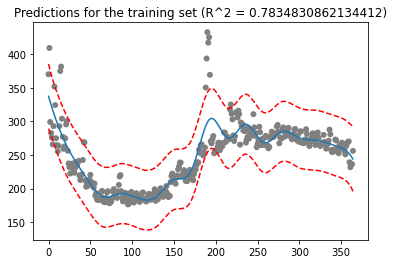

In [16]:
# plot the figure of the training set
plt.figure()
plt.scatter(train_df['day_dif'], train_df['price'], facecolor = 'gray', edgecolors = 'none')
plt.plot(train_df['day_dif'], gam_best.predict(train_df['day_dif']))
plt.plot(train_df['day_dif'], gam_best.prediction_intervals(train_df['day_dif'], width = .95), 
         c='r', ls='--')
plt.title('Predictions for the training set (R^2 = {})'.format(str(r2_train)))
plt.show()

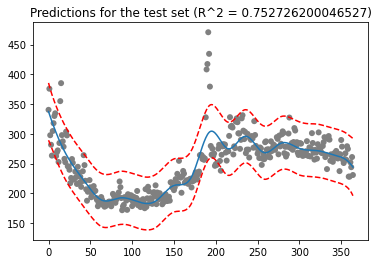

In [17]:
# plot the figure of the test data
plt.figure()
plt.scatter(test_df['day_dif'], test_df['price'], facecolor = 'gray', edgecolors = 'none')
plt.plot(test_df['day_dif'], gam_best.predict(test_df['day_dif']))
plt.plot(test_df['day_dif'], gam_best.prediction_intervals(test_df['day_dif'], width = .95), 
         c='r', ls='--')
plt.title('Predictions for the test set (R^2 = {})'.format(r2_best))
plt.show()

**1.3.4** Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?


*The penalized B-spline with the smoothing parameter = 0.01 performs the best.*

**1.4** It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit. Create a binary indicator of weekend versus non-weekend, and include it in your additive model based on `pygam`.  How does it impact the model's performance?

*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.



In [18]:
df_week = train.iloc[:,-2:].drop_duplicates(subset=['day_dif'])
train_df.index.name = 'index'
train_df = pd.merge(left = train_df, right = df_week, left_on = 'day_dif', right_on = 'day_dif')

# create the weekend variable
train_df['weekend'] = [1 if i in ['Friday','Saturday'] else 0 for i in train_df['wday_wd']]

In [19]:
# add the weekday info to the test set
weekday_int = []
weekday_wd = []

for i in test['date']:
    result = i.weekday()
    weekday_int.append(result)
    weekday_wd.append(get_week_day(result))

test['wday_int'] = weekday_int
test['wday_wd'] = weekday_wd

In [20]:
test

,listing_id,date,available,price,day_dif,wday_int,wday_wd
0,21205442,2018-09-28,t,138.0,357,4,Friday
1,5166870,2018-08-11,t,210.0,309,5,Saturday
2,9698823,2017-10-17,f,NaN,11,1,Tuesday
3,18894466,2018-02-21,f,NaN,138,2,Wednesday
4,6765855,2018-09-22,f,NaN,351,5,Saturday
...,...,...,...,...,...,...,...
314567,2843445,2018-05-11,t,85.0,217,4,Friday
314568,17591837,2017-12-10,t,199.0,65,6,Sunday
314569,19177794,2018-06-17,f,NaN,254,6,Sunday
314570,5075267,2017-12-30,t,188.0,85,5,Saturday


In [21]:
df_week = test.iloc[:,4:7].drop_duplicates(subset=['day_dif'])
test_df.index.name = 'index'
test_df = pd.merge(left = test_df, right = df_week, left_on = 'day_dif', right_on = 'day_dif')

# # create the weekend variable
test_df['weekend'] = [1 if i in ['Friday','Saturday'] else 0 for i in test_df['wday_wd']]

In [22]:
train_df['weekend']= train_df['weekend'].astype("category")
test_df['weekend']= test_df['weekend'].astype("category")

In [23]:
# your code here
candidate_smoothings = [1.e-3, 1.e-2, 1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5]

X = ['day_dif','weekend']

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings),len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(train_df, train_df['price'])):
    train_ = train_df.iloc[train_index,:]
    test_ = train_df.iloc[test_index,:]
    for j, lam in enumerate(candidate_smoothings):
        for k, lam_k in enumerate(candidate_smoothings):
            gam = LinearGAM(s(0, lam=lam)+f(1,lam=lam_k)).fit(train_[X],train_['price'])
            r2 = r2_score(test_['price'], gam.predict(test_[X]))
            scores[i,j,k] = r2
        
#lam_perform = np.mean(scores, axis=0)


In [24]:
lam_0 = (np.argmax(np.mean(scores, axis = 0))+1)//9
lam_1 = (np.argmax(np.mean(scores, axis = 0))+1)%9-1

# fit the best model

gam_best = LinearGAM(s(0, lam = candidate_smoothings[lam_0]) + 
                     f(1, lam = candidate_smoothings[lam_1])).fit(train_df[X],train_df['price'])
r2_test = r2_score(test_df['price'], gam_best.predict(test_df[X]))
r2_train = list(gam_best.statistics_['pseudo_r2'].values())[0]
y_pred_train = gam_best.predict(train_df[X])
y_pred_test = gam_best.predict(test_df[X])

In [25]:
print("The R^2 score for the training set is {}".format(str(round(r2_train,3))))
print("The R^2 score for the test set is {}".format(str(round(r2_test,3))))

The R^2 score for the training set is 0.813
The R^2 score for the test set is 0.785


*The the GAM model that includes both the "day difference" and the "weekend" variables has a larger R^2 both for the training set and the test set, compared with the GAM model that includes only the day difference.*

**1.5** You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices. Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [26]:
train_sort = train_df.sort_values(by = 'price', ascending = False)

In [27]:
expensive  = train_sort.iloc[0:10,]['day_dif']
set(train.loc[train['day_dif'].isin(expensive)]['date'])

{Timestamp('2017-10-06 00:00:00'),
 Timestamp('2017-10-07 00:00:00'),
 Timestamp('2017-10-13 00:00:00'),
 Timestamp('2017-10-20 00:00:00'),
 Timestamp('2017-10-21 00:00:00'),
 Timestamp('2018-04-13 00:00:00'),
 Timestamp('2018-04-14 00:00:00'),
 Timestamp('2018-04-15 00:00:00'),
 Timestamp('2018-04-16 00:00:00'),
 Timestamp('2018-04-17 00:00:00')}

In [28]:
weekend_check  = []
for date in list(set(train.loc[train['day_dif'].isin(expensive)]['date'])):
    print(str(date.date()) + ' ' +  str(get_week_day(date.weekday())))

2018-04-17 Tuesday
2018-04-16 Monday
2017-10-20 Friday
2017-10-13 Friday
2017-10-21 Saturday
2018-04-14 Saturday
2017-10-07 Saturday
2017-10-06 Friday
2018-04-15 Sunday
2018-04-13 Friday


*It seems that there are two ranges of dates that have unusually high prices. They are the weekends in October 2017 and the week from Apr 13 to 17 in 2018. It seems that the popularity in October is a result of the Gran Prix of Gloucester Cyclocross Race, other related sport events, nice weather and increased tourist activities. For Apr 13 to 17 in 2018, the price should be driven by the annual Boston Marathon event, obviously. This shows that popular sport event is a good indicator for the price rise.*

<div class='exercise'><b> Question 2 [50 pts]: Predicting Airbnb Rental Price Through Listing Features </b></div>

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?


**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.

**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

**2.1** First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?



In [30]:
# your code here
train = pd.read_csv('data/listings_train.csv')
test = pd.read_csv('data/listings_test.csv')

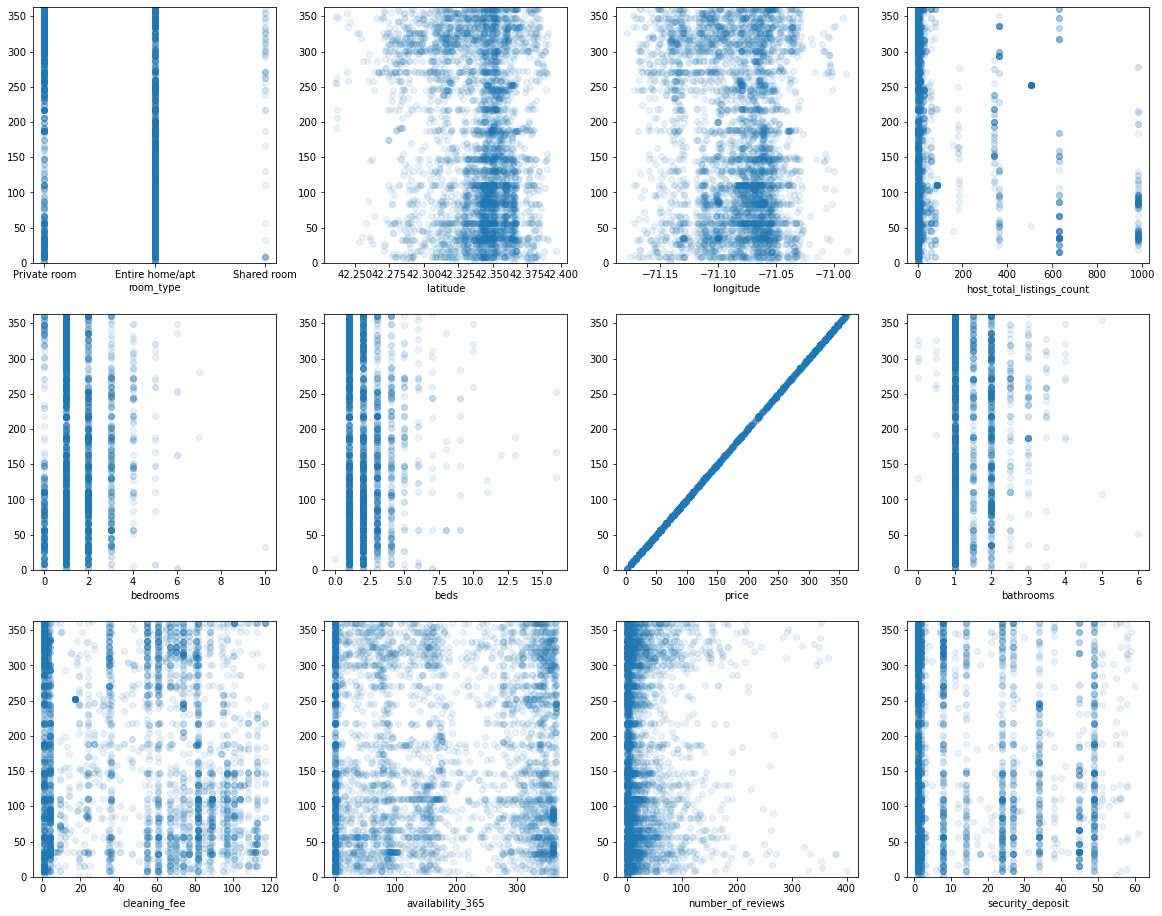

In [31]:
# All of the plots are based on the training set.
train_x = train.drop(labels = 'price', axis = 1)
train_y = train['price']
fig, axs = plt.subplots(3,4,figsize = (20,16))
for i in range(0,train.shape[1],1):
    a = i//4
    b = i%4-1
    axs[a,b].scatter(train.iloc[:,i],train_y, alpha = 0.1)
    axs[a,b].set_ylim([0,np.max(train_y)])
    axs[a,b].set_xlabel(str(train.columns[i]))

*Just by eyeballing the relation between each predictor and the price (except for the seventh graph) represented by the density of scattered dots, it seems that (1) the total number of listings of a host has a downward/negative nonlinear relation with the price, (2) the bedroom number has a upward/positive logarithmic-like nonlinear relation with the price, (3) the bathroom number has a positive logarithmic-like nonlinear relation with the price.* 

**2.2** Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e. basis functions $x, x^2, x^3$ for each predictor $x$) for quantitative predictors.


In [32]:
# your code here

# 1. Linear model (using the ordinary least square method)
train['room_type']= train['room_type'].astype('category')
test['room_type']= test['room_type'].astype('category')
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
train['room_type_cat'] = labelencoder.fit_transform(train['room_type'])
test['room_type_cat'] = labelencoder.fit_transform(test['room_type'])

fit1_lm = sm.ols('price~host_total_listings_count + room_type_cat + latitude \
                + longitude + bathrooms + bedrooms + beds \
                + security_deposit + cleaning_fee + availability_365 + number_of_reviews', 
                 data = train).fit()

test_X = test.drop(labels = ['price','room_type'], axis = 1)

pred1 = fit1_lm.predict(test_X)
prediction_output = fit1_lm.get_prediction(test_X).summary_frame()

In [33]:
r2_ml = r2_score(test['price'],np.array(prediction_output['mean']))
print('The R^2 of the test set for the linear regression is {}.'.format(str(round(r2_ml,3))))

The R^2 of the test set for the linear regression is 0.181.


In [34]:
# 2. Polynomial regression of degree = 3

fit2_lm = sm.ols(formula="price ~ np.vander(host_total_listings_count, 4, increasing=True) -1\
                        + np.vander(latitude, 4, increasing=True) -1 \
                        + np.vander(longitude, 4, increasing=True) -1 \
                        + np.vander(bathrooms, 4, increasing=True) -1 \
                        + np.vander(bedrooms, 4, increasing=True) -1 \
                        + np.vander(beds, 4, increasing=True) -1 \
                        + np.vander(security_deposit, 4, increasing=True) -1 \
                        + np.vander(cleaning_fee, 4, increasing=True) -1 \
                        + np.vander(availability_365, 4, increasing=True) -1 \
                        + np.vander(number_of_reviews, 4, increasing=True) -1",data=train).fit()

test_X_poly = test_X.drop(labels = 'room_type_cat', axis = 1)

poly_predictions = fit2_lm.get_prediction(test_X_poly).summary_frame()

In [35]:
r2_poly = r2_score(test['price'], np.array(poly_predictions['mean']))
print('The R^2 of the test set for the regression of polynomial basis functions of degree 3 is {}.'.format(str(round(r2_poly,3))))

The R^2 of the test set for the regression of polynomial basis functions of degree 3 is 0.111.


*It seems that the multiple linear regression model generates larger R^2 than the regression with polynomial basis functions. This might be because that the polynomial regression is way better at capturing the idiosyncratic patterns of the training set and thus results in an overfit of the training set and a worse prediction for the test set data.*

**2.3** Do you expect any advantage in fitting an additive model to these data, compared to the above models?


*Yes. First, the (generalized) additive model can capture the nonlinear relation between each predictor and the response variable, and so should outperform the multiple linear regression model. Second, it does so without having to resort to polynomial basis functions and thus avoids the risk of overfitting like the polynomial regression model. More specifically, the spline terms in the GAM model by default uses 20 basis functions (according to the pygam documentation), this largely predicts that GAM's better performance.*

**2.4** Fit an additive model using the `pygam` library to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a penalized B-spline basis function on each predictor, tuned using cross-validation on the training set.


In [36]:
# your code here

# In this module, we used the gridsearch functionality of pygam 
# to automatically choose the model based on the cross-validation score.
# We also resorted to the default number of splines here, which is 20.

# set up the X and y dataframes
train_X = train.drop(labels = ['price','room_type'], axis = 1)
test_X = test.drop(labels = ['price','room_type'], axis = 1)

# set up the original grid of lams to search over
lams = np.random.rand(100, len(train_X.columns)) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3

In [37]:
# fit the model with automatic optimization of the lambda parameter
random_gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + 
                       s(5) + s(6) + s(7) + s(8) + s(9) + f(10)).gridsearch(train_X.to_numpy(), np.array(train['price']), lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:57 Time:  0:00:57


In [38]:
r2_gam =  r2_score(test['price'], random_gam.predict(test_X))
print('The R^2 of the test set for the additive model is {}.'.format(str(round(r2_gam,3))))

The R^2 of the test set for the additive model is 0.243.


*The additive model outperforms both the linear and the polynomial model.*

**2.5** Plot and examine the smooth of each predictor for the fitted additive model. What are some useful insights conveyed by these plots?


<Figure size 432x288 with 0 Axes>

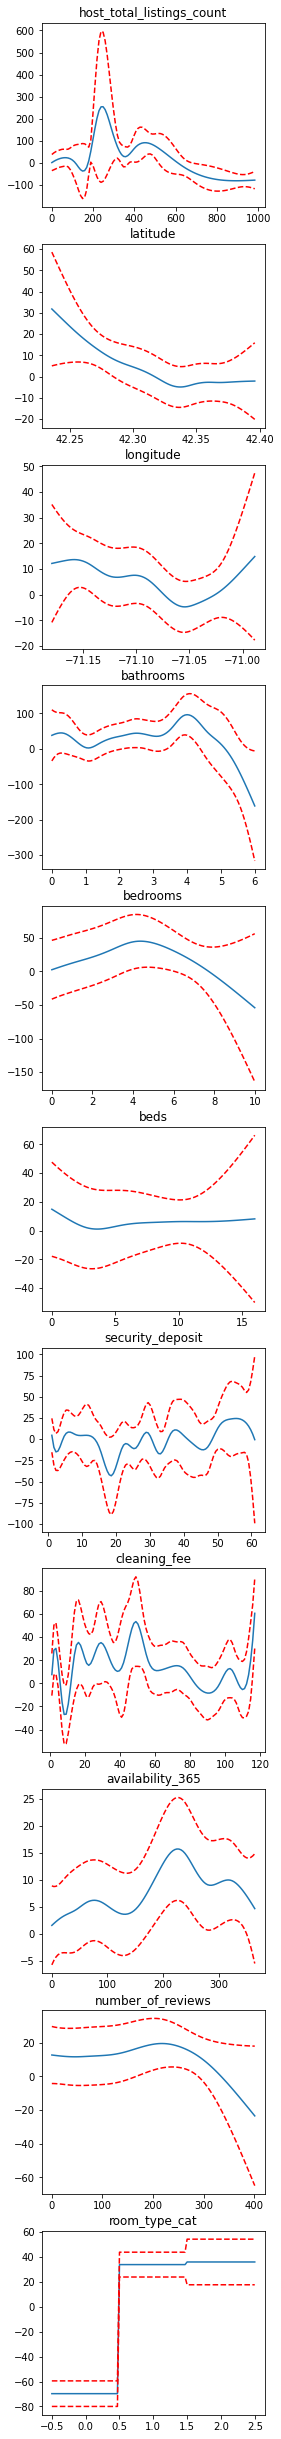

In [39]:
# your code here
## plotting
plt.figure();
fig, axs = plt.subplots(len(train_X.columns),1, figsize = (4,44));

titles = train_X.columns
for i, ax in enumerate(axs):
    XX = random_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], random_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], random_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     if i == 0:
#         ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

**Observations:**
*1. When the total number of listings a host has is smaller than around 250, the price has a positive relation with this predictor and reaches to the peak at 250. After the listings number exceeds 250, the price decreases.*

*2. As for the location, it seems that the farther north the house is, the lower the price would be. Plus, it seems that places in central Boston, whose longitude is around -71.07 ~ -71.07, typically have lower prices.*

*3. When there are more than four bathrooms or more than four bedrooms, the price goes down.*

*4. The price fluctuates around the zero as the number of beds, the security deposit fee, and the cleaning fee increase. There does not seem to be a clear pattern of nolinearity.*

*5. The relation between the price and the number of days that are available seems to be largely concave.*

*6. Concerning the number of reviews, there is a small peak around 400 comments and after that there is a steep decrease of the price.*

*7. It seems that when the room type is "entire home/apt", the price is way lower than when the room type is "private room" or "shared room", which is very surprising unless the price is the unit price of renting, instead of the total rent for the entire property.*

**2.6** Using the outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

*The most important predictors for the house price are the month, the day of the week, whether there are important sport events taking place at the time of renting, the number of bathrooms/bedrooms, the room type, and the "host_total_number_listings.*

*Advice: winter, wednesday, avoid major sport event, mid boston, entire apartment.*